In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt

In [18]:
# ==========================================
# 1. Data Loading & Preprocessing
# ==========================================
# Load the dataset from the CSV file in the same folder
try:
    df = pd.read_csv('jeeves_tennis.csv')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: 'jeeves_tennis.csv' not found. Please ensure the file is in the same directory.")

# --- High Cardinality Trap Analysis ---
# (We calculate this before dropping Day_ID)
def calculate_entropy(y):
    elements, counts = np.unique(y, return_counts=True)
    probabilities = counts / counts.sum()
    return -np.sum(probabilities * np.log2(probabilities))

def calculate_information_gain(data, feature, target_name):
    total_entropy = calculate_entropy(data[target_name])
    vals, counts = np.unique(data[feature], return_counts=True)
    weighted_entropy = sum((counts[i] / sum(counts)) * calculate_entropy(data[data[feature] == vals[i]][target_name]) 
                           for i in range(len(vals)))
    return total_entropy - weighted_entropy

# Check if 'Day_ID' exists in the CSV before calculating (some versions might name it differently)
if 'Day_ID' in df.columns:
    day_id_gain = calculate_information_gain(df, 'Day_ID', 'PlayTennis')
    print(f"Information Gain for Day_ID: {day_id_gain:.4f}")
    
    # Drop Day_ID
    df = df.drop(columns=['Day_ID'])
else:
    print("Note: 'Day_ID' column not found in CSV. Proceeding with remaining features.")

# Continue with the rest of the code (Parts 2-5)...

Dataset loaded successfully.
Information Gain for Day_ID: 0.9815


In [20]:
def find_best_split_continuous(data, attribute, target_name):
    sorted_data = data.sort_values(by=attribute)
    unique_values = sorted_data[attribute].unique()
    best_gain = -1
    
    for i in range(len(unique_values) - 1):
        threshold = (unique_values[i] + unique_values[i+1]) / 2
        left_subset = data[data[attribute] <= threshold]
        right_subset = data[data[attribute] > threshold]
        
        p_left = len(left_subset) / len(data)
        p_right = len(right_subset) / len(data)
        
        current_entropy = (p_left * calculate_entropy(left_subset[target_name])) + \
                          (p_right * calculate_entropy(right_subset[target_name]))
        
        gain = calculate_entropy(data[target_name]) - current_entropy
        if gain > best_gain:
            best_gain = gain
    return best_gain

features = ['Outlook', 'Humidity', 'Wind', 'Temperature']
target = 'PlayTennis'
gains = {}

print("--- Information Gain at Root ---")
for feat in features:
    if feat == 'Temperature':
        gain = find_best_split_continuous(df, feat, target)
    else:
        gain = calculate_information_gain(df, feat, target)
    gains[feat] = gain
    print(f"{feat}: {gain:.4f}")
    

best_feature = max(gains, key=gains.get)
print(f"\nFeature with highest gain: {best_feature}")

--- Information Gain at Root ---
Outlook: 0.3431
Humidity: 0.0539
Wind: 0.0382
Temperature: 0.0239

Feature with highest gain: Outlook


In [21]:
# ==========================================
# 3. Core Logic (Entropy & Continuous Split)
# ==========================================
def find_best_split_continuous(data, attribute, target_name):
    sorted_data = data.sort_values(by=attribute)
    unique_values = sorted_data[attribute].unique()
    
    best_gain = -1
    best_threshold = None
    
    # Try all midpoints
    for i in range(len(unique_values) - 1):
        threshold = (unique_values[i] + unique_values[i+1]) / 2
        
        # Split
        left_subset = data[data[attribute] <= threshold]
        right_subset = data[data[attribute] > threshold]
        
        # Weighted Entropy
        p_left = len(left_subset) / len(data)
        p_right = len(right_subset) / len(data)
        current_entropy = (p_left * calculate_entropy(left_subset[target_name])) + \
                          (p_right * calculate_entropy(right_subset[target_name]))
        
        gain = calculate_entropy(data[target_name]) - current_entropy
        
        if gain > best_gain:
            best_gain = gain
            best_threshold = threshold
            
    return best_threshold, best_gain

In [22]:
find_best_split_continuous(df, 'Temperature', target)

(30.05, 0.02392309702606632)

In [23]:
# ==========================================
# 4. Recursive Tree Construction (The Class)
# ==========================================

class Node:
    def __init__(self, feature=None, threshold=None, value=None, children=None):
        self.feature = feature        # Feature name to split on
        self.threshold = threshold    # Threshold if continuous
        self.value = value            # Class label if leaf
        self.children = children or {} # Dict for discrete branches: {value: Node}
        self.left = None              # Node for continuous <= threshold
        self.right = None             # Node for continuous > threshold

class DecisionTreeID3:
    def __init__(self, min_samples_split=2, max_depth=float('inf')):
        self.root = None
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.target = None
        
    def fit(self, data, target_name):
        self.target = target_name
        self.root = self._build_tree(data, depth=0)
        
    def _build_tree(self, data, depth):
        # Base Case 1: Pure Node
        if len(data[self.target].unique()) == 1:
            return Node(value=data[self.target].iloc[0])
        
        # Base Case 2: No features left or max depth reached
        if len(data.columns) == 1 or len(data) < self.min_samples_split or depth >= self.max_depth:
            return Node(value=data[self.target].mode()[0])
        
        # Find Best Split
        best_feature = None
        best_gain = -1
        best_threshold = None
        is_continuous = False
        
        for feature in data.columns:
            if feature == self.target: continue
            
            # Check type
            if np.issubdtype(data[feature].dtype, np.number):
                thresh, gain = find_best_split_continuous(data, feature, self.target)
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_threshold = thresh
                    is_continuous = True
            else:
                gain = calculate_information_gain(data, feature, self.target)
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    is_continuous = False
                    best_threshold = None
        
        # If no gain (e.g., identical features but diff labels), return mode
        if best_gain == 0:
            return Node(value=data[self.target].mode()[0])

        # Create Node and Recurse
        node = Node(feature=best_feature, threshold=best_threshold)
        
        if is_continuous:
            left_data = data[data[best_feature] <= best_threshold]
            right_data = data[data[best_feature] > best_threshold]
            node.left = self._build_tree(left_data, depth + 1)
            node.right = self._build_tree(right_data, depth + 1)
        else: # Discrete
            unique_vals = data[best_feature].unique()
            for val in unique_vals:
                sub_data = data[data[best_feature] == val]
                node.children[val] = self._build_tree(sub_data, depth + 1)
                
        return node

    def predict_single(self, row, node):
        if node.value is not None:
            return node.value
        
        if node.threshold is not None: # Continuous
            if row[node.feature] <= node.threshold:
                return self.predict_single(row, node.left)
            else:
                return self.predict_single(row, node.right)
        else: # Discrete
            val = row[node.feature]
            if val in node.children:
                return self.predict_single(row, node.children[val])
            else:
                # Handle unseen value (simple fallback: return mode of dataset or just a guess)
                # Ideally, each node should store the majority class of the data that reached it
                return "No" # Default fallback for this dataset

    def predict(self, X):
        return [self.predict_single(row, self.root) for index, row in X.iterrows()]

train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

tree = DecisionTreeID3(max_depth=5)
tree.fit(train_data, 'PlayTennis')

y_pred = tree.predict(test_data)
y_true = test_data['PlayTennis'].values

print("Test Predictions:", y_pred)
print("True Labels:     ", y_true)
print(f"Accuracy: {accuracy_score(y_true, y_pred):.2f}")
print(f"Precision: {precision_score(y_true, y_pred, pos_label='Yes'):.2f}")
print(f"Recall:    {recall_score(y_true, y_pred, pos_label='Yes'):.2f}")

Test Predictions: ['Yes', 'No', 'Yes', 'No', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'No', 'No', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'No', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'No', 'No', 'No', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'No', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'No', 'No', 'No', 'No', 'Yes', 'No', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'No', 'No', 'No', 'No', 'No', 'Yes', 'No', 'Yes', 'No', 'No', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'No']
True Labels:      ['No' 'No' 'Yes' 'No' 'No' 'Yes' 'Yes' 'Yes' 'Yes' 'No' 'No' 'No' 'Yes'
 'Yes' 'Yes' 'No' 'Yes' 'Yes' 'No' 'No' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes'
 'Yes' 'Yes' 'No' 'No' 'No' 'Yes' 'Yes' 'Yes' 'No' 'Yes' 'Yes' 'No' 'Yes'
 'Yes' 'Yes' 'Yes' 'No' 'No' 'No' 'No' 'Yes' 'No' 'Yes' 'Yes' 'Yes' 'Yes'
 'Yes' 'Yes' '

In [24]:
# ==========================================
# 5. Overfitting & Pruning Analysis
# ==========================================
print("\n--- Overfitting Analysis ---")

# 1. Depth on Full Data
full_tree = DecisionTreeID3()
full_tree.fit(df, 'PlayTennis')
# Helper to get depth
def get_max_depth(node):
    if node.value is not None: return 0
    if node.threshold is not None:
        return 1 + max(get_max_depth(node.left), get_max_depth(node.right))
    else:
        return 1 + max([get_max_depth(child) for child in node.children.values()])

print(f"Tree Depth on Clean Data: {get_max_depth(full_tree.root)}")


--- Overfitting Analysis ---
Tree Depth on Clean Data: 11


In [47]:

# 2. Noise Simulation
df_noisy = df.copy()
# Flip 2 random labels (approx 10-15%)
flip_indices = np.random.choice(df_noisy.index, size=2, replace=False)
for idx in flip_indices:
    df_noisy.at[idx, 'PlayTennis'] = 'No' if df_noisy.at[idx, 'PlayTennis'] == 'Yes' else 'Yes'

noisy_tree = DecisionTreeID3()
noisy_tree.fit(df_noisy, 'PlayTennis')
print(f"Tree Depth on Noisy Data: {get_max_depth(noisy_tree.root)}")

Tree Depth on Noisy Data: 14


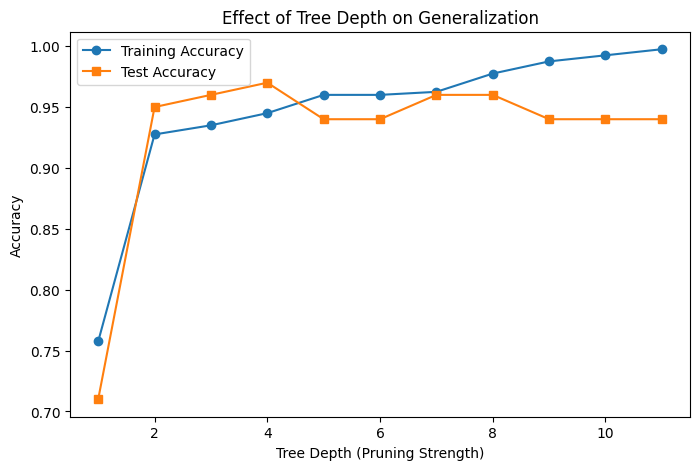

In [50]:
# 3. Post-Pruning Experiment (Simulation Plot)
# Simulating the effect of max_depth pruning on accuracy
depths = range(1, 12)
train_accs = []
test_accs = []

for d in depths:
    t = DecisionTreeID3(max_depth=d)
    t.fit(train_data, 'PlayTennis')
    train_accs.append(accuracy_score(train_data['PlayTennis'], t.predict(train_data)))
    test_accs.append(accuracy_score(test_data['PlayTennis'], t.predict(test_data)))

plt.figure(figsize=(8, 5))
plt.plot(depths, train_accs, label='Training Accuracy', marker='o')
plt.plot(depths, test_accs, label='Test Accuracy', marker='s')
plt.xlabel('Tree Depth (Pruning Strength)')
plt.ylabel('Accuracy')
plt.title('Effect of Tree Depth on Generalization')
plt.legend()
plt.show()